In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from xgboost import XGBRegressor

In [3]:
df = pd.read_csv("fish.csv")

In [9]:
coding = {k:v for k, v in zip(df[' c'].unique(), range(df['Species'].nunique()))}

In [11]:
df['Species'] = df.Species.replace(coding)

In [225]:
X = df.drop('Species', axis=1)
y = df['Species']

In [226]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [227]:
X_train.head()

,Weight,Length1,Length2,Length3,Height,Width
89,135.0,20.0,22.0,23.5,5.8750,3.5250
100,197.0,23.5,25.6,27.0,6.5610,4.2390
9,500.0,28.5,30.7,36.2,14.2266,4.9594
43,150.0,20.4,22.0,24.7,5.8045,3.7544
62,60.0,14.3,15.5,17.4,6.5772,2.3142


In [228]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

In [426]:
import itertools
import datetime
from sklearn.model_selection import GridSearchCV

class MLTuner:
    def __init__(self):
        pass
    
    def combinations_generator(self, searching_space):
        hyperparameters = sorted(searching_space)
        combinations = itertools.product(*(searching_space[hyperparameter] for hyperparameter in hyperparameters))
        for combination in combinations:
            yield {k:[v] for k, v in zip(hyperparameters, combination)}

    def get_space_size(self, searching_space):
        prodcut = 1
        for i in range(len(list(searching_space.values()))):
            prodcut *= len(list(searching_space.values())[i])

        return prodcut
    
    def fit(self, primary_estimator, secondary_estimator, X, y):
        self.primary_estimator = primary_estimator
        self.secondary_estimator = secondary_estimator
        self.X = X
        self.y = y
        self.searching_space = searching_space
    
    def search(self, searching_space, cv, min_sampling_size, min_checking_freq, secondary_scoring_threshold):
        hp_samples = pd.DataFrame(columns=list(searching_space.keys()))
        searching_space = {k:list(v) for k, v in searching_space.items()}
        
        searching_space_size = get_space_size(self.searching_space)
        
        secondary_score_track = []
        
        count = 1
        for p in self.combinations_generator(self.searching_space):
            estimator = GridSearchCV(self.primary_estimator, p, verbose=0)
            estimator.fit(self.X, self.y)
            sample = pd.DataFrame([v[0] for v in p.values()] + [estimator.best_score_], index=[k for k in p.keys()] + ["score"]).T
            hp_samples = hp_samples.append(sample)
            
            if len(hp_samples) >= min_sampling_size:
                if len(hp_samples) % min_checking_freq == 0:
                    X_sample = hp_samples.drop('score', axis=1)
                    y_sample = hp_samples['score']
                    secondary_score = cross_val_score(estimator=self.secondary_estimator, X=X_sample, y=y_sample, cv=cv, scoring="neg_mean_absolute_error").mean()
                    now = datetime.datetime.now()
                    current_time = now.strftime("%H:%M:%S")
                    print(f"{current_time}  {count}/{searching_space_size}  Secondary Score: {secondary_score}")
                    secondary_score_track.append(secondary_score)
                    
                    if secondary_score >= secondary_scoring_threshold:
                        print("Done Sampling.")
                        break
                
            count += 1
        
        self.secondary_score_track = secondary_score_track
        self.hp_samples = hp_samples

In [427]:
searching_space = {
    "learning_rate": [0.001, 0.01, 0.1], 
    "max_depth":np.arange(1, 16), 
    "n_estimators":[int(i) for i in np.arange(1, 1000, 10)]
}

In [428]:
xgbc = XGBClassifier(use_label_encoder=False, verbosity=0)
xgbr = XGBRegressor()
mlt = MLTuner()
mlt.fit(xgbc, xgbr, X_train_std, y_train)
mlt.search(searching_space, 2, 1, 100, -0.0001)

12:47:46	10/4500	Secondary Score: -0.003773930867513009
12:48:07	20/4500	Secondary Score: -0.0067179653437241076
12:48:42	30/4500	Secondary Score: -0.010926607709000051
12:49:30	40/4500	Secondary Score: -0.014560401059579162
12:50:32	50/4500	Secondary Score: -0.009807113295016098
12:51:49	60/4500	Secondary Score: -0.005414528483929865
12:53:20	70/4500	Secondary Score: -0.005631840273460269
12:55:04	80/4500	Secondary Score: -0.005941233984802103
12:57:03	90/4500	Secondary Score: -0.006210388400128521
12:59:16	100/4500	Secondary Score: -0.006451248946397224
12:59:26	110/4500	Secondary Score: -0.006963236402617156
12:59:57	120/4500	Secondary Score: -0.005399183152954366
13:00:49	130/4500	Secondary Score: -0.005742780725028341
13:02:03	140/4500	Secondary Score: -0.007800915295539686
13:03:38	150/4500	Secondary Score: -0.011316969805869498
13:05:34	160/4500	Secondary Score: -0.015218066862527873
13:07:51	170/4500	Secondary Score: -0.019382641060374677
13:10:30	180/4500	Secondary Score: -0.0

KeyboardInterrupt: 

In [ ]:
mlt.

In [429]:
xgbr = XGBRegressor()
xgbr.fit(mlt.hp_samples.drop('score', axis=1), mlt.hp_samples['score'])

AttributeError: 'MLTuner' object has no attribute 'hp_samples'

In [352]:
%%time
xgbr.predict(pd.DataFrame([0.0001, 4, 113], index=['learning_rate', 'max_depth', 'n_estimators']).T)

CPU times: user 4.11 ms, sys: 5.65 ms, total: 9.76 ms
Wall time: 7.49 ms


array([0.7082589], dtype=float32)

In [358]:
%%time
 cross_val_score(xgbc, X_train_std, y_train, cv=5).mean()

CPU times: user 5.29 s, sys: 4.26 s, total: 9.55 s
Wall time: 1.85 s


0.6884057971014493

In [388]:
res = pd.DataFrame(columns=['learning_rate', 'max_depth', 'n_estimators', 'acc'])
best_acc = 0
for i in np.linspace(0.001, 1):
    for j in range(1, 17):
        for k in np.arange(1, 500):
            acc = xgbr.predict(pd.DataFrame([i, j, k], index=['learning_rate', 'max_depth', 'n_estimators']).T)
            res = res.append(pd.DataFrame([i, k, k] + [acc], index=['learning_rate', 'max_depth', 'n_estimators', 'acc']).T)
            if best_acc == 0:
                best_acc = acc
                print(i, j, k, acc)
                
            else:
                if acc > best_acc:
                    best_acc = acc
                    
                    print(i, j, k, acc)

0.001 1 1 [0.6184339]
0.001 1 57 [0.62213355]
0.001 1 168 [0.6312038]
0.001 1 390 [0.6389774]
0.001 2 57 [0.6912776]
0.001 2 168 [0.6919182]
0.001 2 279 [0.7027181]
0.001 2 390 [0.7051462]
0.001 3 57 [0.70643145]
0.001 4 57 [0.7082589]
0.001 6 279 [0.7082776]
0.041775510204081635 2 168 [0.7119191]
0.041775510204081635 2 279 [0.7144641]
0.041775510204081635 2 390 [0.7147724]


In [417]:
import matplotlib.pyplot as plt

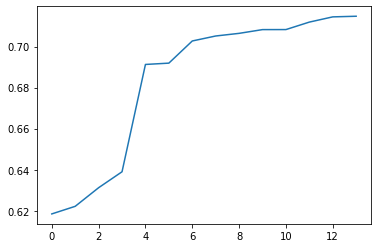

In [418]:
plt.plot([0.6184339, 0.62213355, 0.6312038, 0.6389774, 0.6912776, 0.6919182, 0.7027181, 0.7051462, 0.70643145, 0.7082589, 0.7082776, 0.7119191, 0.7144641, 0.7147724])

In [390]:
res['acc'] = res.acc.apply(lambda x: x[0])

In [415]:
res.sort_values('acc', ascending=False)

,learning_rate,max_depth,n_estimators,acc
0,0.041776,423,423,0.714772
0,0.062163,394,394,0.714772
0,0.041776,421,421,0.714772
0,0.041776,420,420,0.714772
0,0.041776,419,419,0.714772
...,...,...,...,...
0,0.021388,34,34,0.606126
0,0.021388,33,33,0.606126
0,0.021388,32,32,0.606126
0,0.021388,31,31,0.606126


In [404]:
xgbc = XGBClassifier(learning_rate=0.041776, max_depth=423, n_estimators=423, use_label_encoder=False)

In [405]:
cross_val_score(xgbc, X_train_std, y_train, cv=5).mean()

0.6884057971014492

In [407]:
xgbc = XGBClassifier(learning_rate=0.010, max_depth=4, n_estimators=112, use_label_encoder=False)

In [408]:
cross_val_score(xgbc, X_train_std, y_train, cv=5).mean()

0.7228260869565217

In [409]:
xgbc = XGBClassifier(use_label_encoder=False)
cross_val_score(xgbc, X_train_std, y_train, cv=5).mean()

0.6884057971014493